Модель отткока клиентов оператора связи 

Задача проекта

Оператор связи «Ниединогоразрыва.ком» предоставляет два основных типа услуг: Стационарную телефоннию и Интернет. Оператор хочет научиться прогнозировать отток клиентов (Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.)

Предоставленные оператором данные актуальны на 01.02.20 и хранятся в папке `/datasets/final_provider/`, содержат полученную из разных источников информацию:

1. о контрактах (`contract.csv`): 
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и двухгодовой,
- PaperlessBilling – электронный документ об оплате,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги

2. о клиентах(`personal.csv`):
- gender - пол
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- Dependents – наличие иждивенцев

3. об услугах интернета (`internet.csv`)
- InternetService - тип подключения (оптика или dsl)
- OnlineSecurity - блокировка небезопасных сайтов
- OnlineBackup - облачное хранилище файлов для резервного копирования данных
- DeviceProtection - антивирус 
- TechSupport - выделенная линия технической поддержки
- StreamingTV - стриминговое телевидение 
- StreamingMovies - каталог фильмов

4. об услугах телефонии (`phone.csv`):
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

*Во всех файлах столбец customerID содержит код клиента.*

План работы:
1. Исседовательский анализ данных
2. Подготовка признаков
3. Обучение моделей 
4. Подбор гиперпараметров


# Исседовательский анализ данных

План

1. Открытие файлов с данными и изучение информации

2. Подготовка данных
- Замена названия столбцов.
- Преобразование данных в нужные типы.
- Обработка пропусков при необходимости.
- Выделение признаков 

3. Первичный анализ признаков


In [1]:
#!pip install catboost
#!pip install phik


In [2]:
# Импорт библиотек
import pandas as pd
import lightgbm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import phik

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, RFECV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

# модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [3]:
TEST_SIZE = 0.2
RANDOM_STATE = 80822

## Загрузка и просмотр данных

In [4]:
# Загрузка данных
df_keys = ["contract", "personal", "internet", "phone"]
df = {}
for key in df_keys:
    df[key] = pd.read_csv(f'f:/Yandex-Practicum/datasets/final_provider/{key}.csv')

In [5]:
# Функция просмотра датафреймов
def df_study(dframe):
    print("----------------10 случайных строк----------------\n")
    display(dframe.sample(10, random_state=RANDOM_STATE))
    print("\n------------------------Инфо------------------------\n")
    dframe.info()    
    print(f"\nПовторяющихся ID: {dframe['customerID'].size - pd.unique(dframe['customerID']).size},",
          f"пропусков: {dframe.isna().sum()[dframe.isna().sum() != 0].sort_values(ascending=False).count()},",
          f"явных дубликатов: {dframe.duplicated().sum()}")    

In [6]:
df_study(df['contract'])

----------------10 случайных строк----------------



customerID   BeginDate              EndDate            Type  \
4724  5073-RZGBK  2015-12-01                   No        One year   
3244  7966-YOTQW  2019-04-01                   No  Month-to-month   
81    8108-UXRQN  2019-03-01                   No  Month-to-month   
3215  3481-JHUZH  2016-09-01                   No  Month-to-month   
5531  2137-DQMEV  2014-06-01                   No        One year   
5253  2851-STERV  2017-03-01                   No        One year   
724   5244-IRFIH  2017-01-01  2019-10-01 00:00:00  Month-to-month   
3449  5473-KHBPS  2015-10-01                   No        One year   
1561  1157-BQCUW  2019-10-01  2019-11-01 00:00:00  Month-to-month   
5679  5229-PRWKT  2019-03-01  2019-11-01 00:00:00  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
4724              Yes  Bank transfer (automatic)           80.05       4042.2  
3244              Yes    Credit card (automatic)           54.50        568.2  
81                 No           Electronic check           50.55       565.35  
3215              Yes           Electronic check           80.25         3439  
5531               No               Mailed check           44.80      2983.65  
5253              Yes           Electronic check           73.00      2471.25  
724               Yes           Electronic check           94.50      3105.55  
3449              Yes    Credit card (automatic)           95.70      4976.15  
1561              Yes           Electronic check           74.95        74.95  
5679              Yes           Electronic check           86.55       649.65


------------------------Инфо------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Повторяющихся ID: 0, пропусков: 0, явных дубликатов: 0


In [7]:
df_study(df['personal'])

----------------10 случайных строк----------------



customerID  gender  SeniorCitizen Partner Dependents
4724  5073-RZGBK  Female              0     Yes        Yes
3244  7966-YOTQW    Male              0      No         No
81    8108-UXRQN  Female              0     Yes        Yes
3215  3481-JHUZH    Male              0     Yes         No
5531  2137-DQMEV    Male              0     Yes        Yes
5253  2851-STERV    Male              1      No         No
724   5244-IRFIH    Male              1     Yes         No
3449  5473-KHBPS  Female              0     Yes        Yes
1561  1157-BQCUW    Male              0      No         No
5679  5229-PRWKT    Male              0      No         No


------------------------Инфо------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Повторяющихся ID: 0, пропусков: 0, явных дубликатов: 0


In [8]:
df_study(df['internet'])

----------------10 случайных строк----------------



customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
1243  1436-ZMJAN             DSL             No           No              Yes   
3131  5276-KQWHG     Fiber optic             No           No               No   
2944  8617-ENBDS     Fiber optic             No           No              Yes   
5190  2810-FTLEM             DSL            Yes           No               No   
4194  5701-GUXDC             DSL            Yes           No              Yes   
1274  3584-WKTTW     Fiber optic            Yes           No              Yes   
4968  8778-LMWTJ     Fiber optic            Yes           No               No   
2597  9494-BDNNC     Fiber optic             No          Yes              Yes   
3200  2777-PHDEI     Fiber optic             No           No               No   
4135  0774-RMNUW             DSL            Yes          Yes               No   

     TechSupport StreamingTV StreamingMovies  
1243          No         Yes             Yes  
3131          No          No              No  
2944          No          No              No  
5190          No          No              No  
4194          No          No              No  
1274         Yes         Yes             Yes  
4968          No          No              No  
2597          No          No             Yes  
3200          No         Yes              No  
4135         Yes         Yes             Yes


------------------------Инфо------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Повторяющихся ID: 0, пропусков: 0, явных дубликатов: 0


In [9]:
df_study(df['phone'])

----------------10 случайных строк----------------



customerID MultipleLines
1736  3143-ILDAL           Yes
3562  3882-IYOIJ           Yes
5092  9670-BPNXF            No
801   1258-YMZNM           Yes
61    3410-YOQBQ            No
2435  8166-ORCHU            No
3900  2186-QZEYA           Yes
5025  3803-KMQFW            No
6354  0639-TSIQW           Yes
4794  9479-HYNYL            No


------------------------Инфо------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Повторяющихся ID: 0, пропусков: 0, явных дубликатов: 0


### Вывод
В результате загрузки и просмотра данных установлено:
- Массив контрактов и персональных данных имеют одинаковые размеры, 
- Массивы "Интернет" и "телефон" имееют меньшее количество записей, что вероятно обусловлено тем, что часть клиентов использует только одну услугу.
- Во всех массивах отсутствуют явные пропуски и дубликаты. 
- Названия столбцов не в змеином регистре. 
- Большинство столбцов имеют тип object, столбец TotalCharges можно преобразовать в числовой, BeginDate в datetime.
- Повторов ID в данных нет.
- Целевой признак может быть извлечен из столбца EndDate: если указана дата, то клиент ушел, если указано "No", то продолжает пользоваться услугами.

## Подготовка данных

### Переименование столбцов

In [10]:
# Названия столбцов до переименования в змеиный регистр
[df[key].columns for key in df_keys]

[Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
        'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
       dtype='object'),
 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object'),
 Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
       dtype='object'),
 Index(['customerID', 'MultipleLines'], dtype='object')]

In [11]:
df['contract'].rename({'customerID':'customer_id', 
                       'BeginDate':'begin_date', 
                       'EndDate':'end_date', 
                       'Type':'type', 
                       'PaperlessBilling':'paperless_billing',
                       'PaymentMethod':'payment_method', 
                       'MonthlyCharges':'monthly_charges', 
                       'TotalCharges':'total_charges'},
                      axis=1, inplace=True)

df['personal'].rename({'customerID':'customer_id', #'gender':'gender',                       
                       'SeniorCitizen':'senior_citizen', 
                       'Partner':'partner', 
                       'Dependents':'dependents'},
                      axis=1, inplace=True)

df['internet'].rename({'customerID':'customer_id', 
                       'InternetService':'internet_service', 
                       'OnlineSecurity':'online_security', 
                       'OnlineBackup':'online_backup',
                       'DeviceProtection':'device_protection', 
                       'TechSupport':'tech_support', 
                       'StreamingTV':'streaming_tv', 
                       'StreamingMovies':'streaming_movies'},
                      axis=1, inplace=True)

df['phone'].rename({'customerID':'customer_id',
                    'MultipleLines':'multiple_lines'},
                   axis=1, inplace=True)

# Названия столбцов после переименования в змеиный регистр
[df[key].columns for key in df_keys]

[Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
        'payment_method', 'monthly_charges', 'total_charges'],
       dtype='object'),
 Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object'),
 Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
        'device_protection', 'tech_support', 'streaming_tv',
        'streaming_movies'],
       dtype='object'),
 Index(['customer_id', 'multiple_lines'], dtype='object')]

### Изменение типов данных в столбцах

#### Преобразование значений 'total_charges' в числовые

In [12]:
# преобразование значений столбца трат в числовые
df['contract']['total_charges'] = pd.to_numeric(df['contract']['total_charges'], errors = 'coerce')
df['contract']['total_charges'].sort_values()

1654    18.80
6489    18.85
1151    18.85
4939    18.90
583     19.00
        ...  
3826      NaN
4380      NaN
5218      NaN
6670      NaN
6754      NaN
Name: total_charges, Length: 7043, dtype: float64

In [13]:
print('Пропусков:',df['contract']['total_charges'].isna().sum(),'\n\nЗаписи с пропусками ')
df['contract'][df['contract']['total_charges'].isna()]

Пропусков: 11 

Записи с пропусками 


customer_id  begin_date end_date      type paperless_billing  \
488   4472-LVYGI  2020-02-01       No  Two year               Yes   
753   3115-CZMZD  2020-02-01       No  Two year                No   
936   5709-LVOEQ  2020-02-01       No  Two year                No   
1082  4367-NUYAO  2020-02-01       No  Two year                No   
1340  1371-DWPAZ  2020-02-01       No  Two year                No   
3331  7644-OMVMY  2020-02-01       No  Two year                No   
3826  3213-VVOLG  2020-02-01       No  Two year                No   
4380  2520-SGTTA  2020-02-01       No  Two year                No   
5218  2923-ARZLG  2020-02-01       No  One year               Yes   
6670  4075-WKNIU  2020-02-01       No  Two year                No   
6754  2775-SEFEE  2020-02-01       No  Two year               Yes   

                 payment_method  monthly_charges  total_charges  
488   Bank transfer (automatic)            52.55            NaN  
753                Mailed check            20.25            NaN  
936                Mailed check            80.85            NaN  
1082               Mailed check            25.75            NaN  
1340    Credit card (automatic)            56.05            NaN  
3331               Mailed check            19.85            NaN  
3826               Mailed check            25.35            NaN  
4380               Mailed check            20.00            NaN  
5218               Mailed check            19.70            NaN  
6670               Mailed check            73.35            NaN  
6754  Bank transfer (automatic)            61.90            NaN

11 контрактов без суммарных трат, они оформлены в день выгрузки данных и еще не потрачены средства

Пропуски заполняются нулями (также можно исключить их из выборки , тк они малоинформативны для определения оттока клиентов).

In [14]:
# Заполнение трат для контрактов от 01.02.2020 с пропущенными суммарными тратами
df['contract'].fillna(0, inplace=True)

#### Преобразование значений 'begin_date' в  datetime

In [15]:
print(df['contract']['begin_date'].sort_values())
df['contract']['begin_date'] = pd.to_datetime(df['contract']['begin_date'])

4513    2013-10-01
4610    2013-10-01
3439    2013-10-01
975     2013-11-01
3040    2013-11-01
           ...    
3331    2020-02-01
6670    2020-02-01
936     2020-02-01
3826    2020-02-01
6754    2020-02-01
Name: begin_date, Length: 7043, dtype: object


### Выделение признаков "Время жизни" клиента и целевого "Клиент ушел"

In [16]:
# Добавление нового признака "время жизни", для клиентов, которые продолжают пользоваться услугами, время определяется до даты выгрузки данных. 01.02.2020 
df['contract']['lifetime'] = (pd.to_datetime(df['contract']['end_date'], errors = 'coerce').fillna(pd.to_datetime('2020-02-01')) - df['contract']['begin_date']).dt.days


In [17]:
# Выделение целевого признака "Клиент ушел"
df['contract']['target'] = (df['contract']['end_date'] != 'No') * 1

In [18]:
# Просмотр целевого признака
df['contract']['target']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: target, Length: 7043, dtype: int32

In [19]:
# Просмотр итоговой таблицы контрактов
df['contract'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   lifetime           7043 non-null   int64         
 9   target             7043 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(5)
memory usage: 522.8+ KB


### Вывод
- Переименованы столбцы в змеиный регистр
- Преобразованы значения столбца 'total_charges' в числовые, есть пропуски в значениях для клиентов зарегистрированных в день выгрузки данных, пропуски заполнены нулями.
- Преобразованы значения столбца 'begin_date' в datetime
- выделен признак время жизни клиентов
- выделен целевой признак "клиент ушел" 

## Анализ признаков

In [20]:
# Доля целевого признака
df['contract']['target'].mean()

0.2653698707936959

In [21]:
print("Уникальные значения категориальных данных о контрактах") 
for i in ['type','paperless_billing','payment_method']:
    print(i, pd.unique(df['contract'][i]))

Уникальные значения категориальных данных о контрактах
type ['Month-to-month' 'One year' 'Two year']
paperless_billing ['Yes' 'No']
payment_method ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [22]:
# просмотр уникальных значений
for key in ['personal','internet','phone']:
    print(f'\nДатафрейм {key}, уникальные значения категориальных данных')
    for i in df[key].drop('customer_id',axis=1).columns:
        print(i, pd.unique(df[key][i]))


Датафрейм personal, уникальные значения категориальных данных
gender ['Female' 'Male']
senior_citizen [0 1]
partner ['Yes' 'No']
dependents ['No' 'Yes']

Датафрейм internet, уникальные значения категориальных данных
internet_service ['DSL' 'Fiber optic']
online_security ['No' 'Yes']
online_backup ['Yes' 'No']
device_protection ['No' 'Yes']
tech_support ['No' 'Yes']
streaming_tv ['No' 'Yes']
streaming_movies ['No' 'Yes']

Датафрейм phone, уникальные значения категориальных данных
multiple_lines ['No' 'Yes']


### Вывод
В выборке около четверти клиентов отказались от услуг.
Признаки тип контракта и метод оплаты многокатегориальные, остальные признаки бинарные. Пропусков в признаках нет. 

## Вывод по разделу 1

Загружены данные, произведена их первичная подготовка

# Подготовка признаков
План 
- собрать признаки в один датафрейм
- генерация новых признаков
- заполнить пропуски для клиентов, использующих только одну услугу 
- закодировать категориальные признаки
- просмотр корреляции и ассоциации признаков
- выделение обучающей и тестовой выборок 

## Объединение таблиц, заполнение пропусков


In [23]:
dff = df['contract'].merge(df['personal'], how='left',on='customer_id')
dff = dff.merge(df['internet'], how='left',on='customer_id')
dff = dff.merge(df['phone'], how='left',on='customer_id')

In [24]:
# проверка, что нет пользователей, не использующих ни одну из услуг 
dff[(dff['internet_service'].isna() & dff['multiple_lines'].isna())].size

0

In [25]:
# просмотр пропусков, появившихся в результате объединения таблиц 
dff.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
lifetime                0
target                  0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [26]:
# Введение дополнительных признаков использования интернета, телефонии, обеих услуг.
dff['uses_internet'] = (~dff['internet_service'].isna()) * 1
dff['uses_phone'] = (~dff['multiple_lines'].isna()) * 1
dff['uses_both'] = (dff['uses_internet'] * dff['uses_phone'])


In [27]:
# В части полей можно заполнить существующими значениями, например, для пользователей телефонии указать, что нет онлайн бэкапа, но в части полей всеравно будет вводиться новая категория, например, в типе интернет подключения - категория "нет".
dff.loc[:,'internet_service':'multiple_lines'] = dff.loc[:,'internet_service':'multiple_lines'].fillna('No')

In [28]:
# проверка отсутсвия пропусков после заполнения
print(f"Осталось пропусков: {dff.isna().sum().max()}")

Осталось пропусков: 0


## Добавление признаков

In [29]:
#dff['new1'] = dff['total_charges']/dff['monthly_charges'] 
#dff['new2'] = dff['total_charges']/(dff['lifetime']+1) # Признак средняя абон плата
#dff['new3'] = round(dff['lifetime']/30) # Признак время жизни в месяцах

# Добавление признака суммарное количество подключенных допуслуг
dff['amount_addit_serv'] = (dff.loc[:,'online_security':'multiple_lines'] == 'Yes').sum(axis=1)

# Добавление признака увеличение стоимости оплаты: из текущей абон платы вычитается средняя за все время использования
dff['fee_increase'] = dff['monthly_charges'] - dff['total_charges']/(dff['lifetime']+1)*30 

## Кодирование признаков 

In [30]:
# Кодирование бинарных категориальных признаков
dff.replace({'No':0, 'Yes':1, 'Male':0, 'Female':1}, inplace=True)
dff['type_num'] = dff['type'].replace({'Month-to-month':1, 'One year':12, 'Two year':24})
# просмотр типов столбцов
dff.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing             int64
payment_method               object
monthly_charges             float64
total_charges               float64
lifetime                      int64
target                        int32
gender                        int64
senior_citizen                int64
partner                       int64
dependents                    int64
internet_service             object
online_security               int64
online_backup                 int64
device_protection             int64
tech_support                  int64
streaming_tv                  int64
streaming_movies              int64
multiple_lines                int64
uses_internet                 int32
uses_phone                    int32
uses_both                     int32
amount_addit_serv             int64
fee_increase                float64
type_num                    

Оcтались столбцы типа object для многокатегориальных признаков - type, payment_method, internet_service. Эти категории не порядковые, поэтому для них применяется прямое кодирование (One-Hot Encoding)

In [31]:
# OHE кодирование многокатегориальных признаков
cat_features = ['type', 'payment_method', 'internet_service']
dff = pd.get_dummies(dff, columns=cat_features, drop_first=True)

In [32]:
dff.dtypes

customer_id                                       object
begin_date                                datetime64[ns]
end_date                                          object
paperless_billing                                  int64
monthly_charges                                  float64
total_charges                                    float64
lifetime                                           int64
target                                             int32
gender                                             int64
senior_citizen                                     int64
partner                                            int64
dependents                                         int64
online_security                                    int64
online_backup                                      int64
device_protection                                  int64
tech_support                                       int64
streaming_tv                                       int64
streaming_movies               

## Расчет $\phi$-корреляции признаков

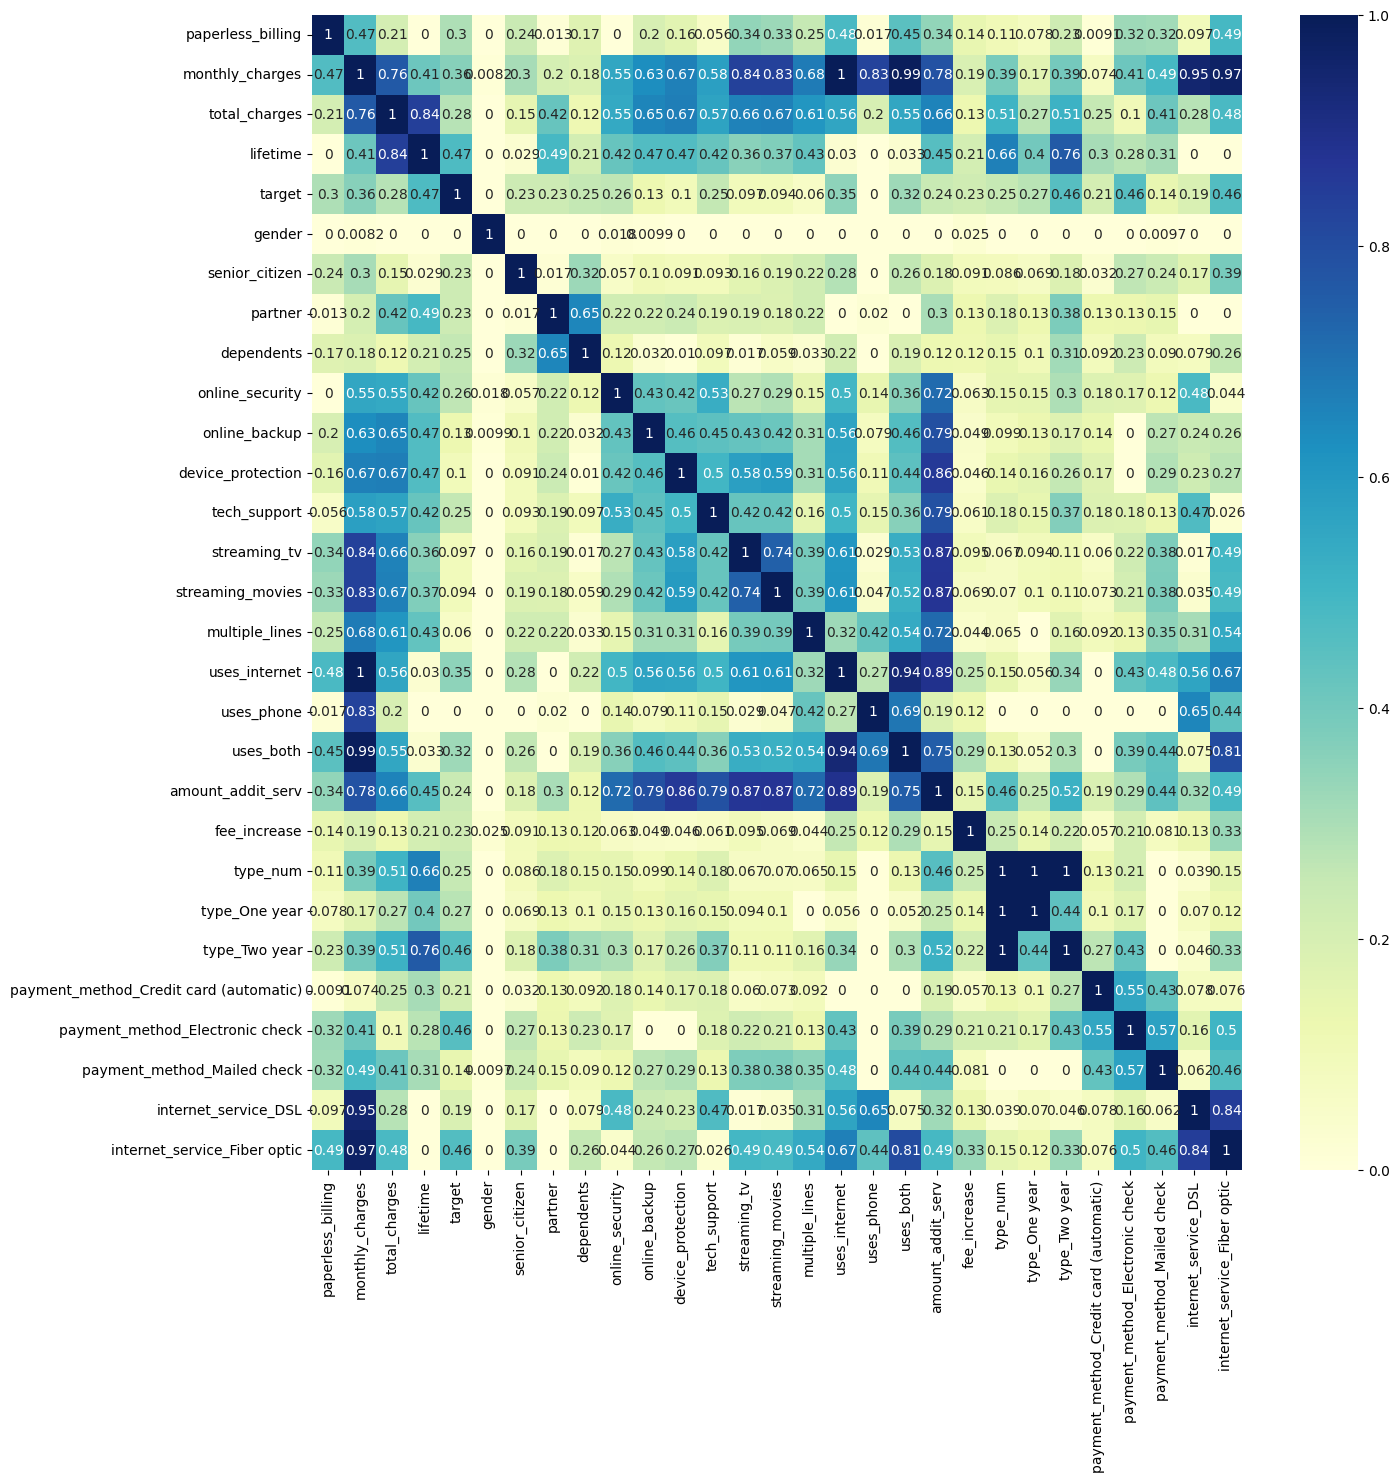

In [33]:
#  phik Корреляция всех признаков 
f, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(dff.drop(['customer_id','begin_date','end_date'],axis=1)
            .phik_matrix(interval_cols= ['monthly_charges', 'total_charges', 'lifetime', 'amount_addit_serv', 'fee_increase','type_num']),
           cmap="YlGnBu", annot=True);

Наибольшая $\phi$-корреляция для признаков время жизни и способ оплаты, тип подключения, период оплаты . Признаки пол и использование телефонии незначимы. 

## Подготовка обучающей и тестовой выборок

In [34]:
# Из признаков исключаются даты, id, целевой признак, пол, использование телефонии
features = dff.drop(['customer_id','begin_date','end_date','target','uses_phone','gender'],axis=1)
target = dff['target']

# разделение на обучающую и тестовую выборки
features_train,features_test,target_train,target_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Создание, кросс-валидация моделей; влияние признаков

План 
- Создать базовые модели с автоматической балансировкой классов для кросс-валидации и выбора лучших моделей (для логистической регрессии создать пайплайн со скалером)
- Исследовать важность признаков: встроенные оценки важности, влияние исключения не важных признаков на метрику
- Аналогично исследовать методы устранения дисбаланса downsampling и upsampling

## Кросс-валидация моделей с различной балансировкой классов

### Автоматическая балансировка классов в моделях

In [35]:
# Создание моделей с автоматическим балансированием классов
model = {}

model['CBC'] = Pipeline([("scaler", StandardScaler()),("classifier", CatBoostClassifier(random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced'))])
model['LGBMC'] = Pipeline([("scaler", StandardScaler()),("classifier", LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model['DTС'] = Pipeline([("scaler", StandardScaler()),("classifier", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model['RFC'] = Pipeline([("scaler", StandardScaler()),("classifier", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model['LR'] = Pipeline([("scaler", StandardScaler()),("classifier", LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))])


In [36]:
scores = {}
best_score = {'best_model':[],'auc-roc':0}
for model_type in ['CBC','LGBMC','DTС','RFC','LR']:
    scores[model_type] = cross_validate(model[model_type], features_train, target_train, scoring=('accuracy','roc_auc'), cv=5, n_jobs=-1)
    ar = scores[model_type]["test_roc_auc"].mean()
    print(f'Scores модели {model_type}: ACC - {scores[model_type]["test_accuracy"].mean():.4f}, ROC-AUC - {ar:.4f}')
    if ar >   best_score ['auc-roc']:
        best_score ['auc-roc'] = ar
        best_score ['best_model'] = model_type
print(best_score)

Scores модели CBC: ACC - 0.8048, ROC-AUC - 0.8872
Scores модели LGBMC: ACC - 0.8158, ROC-AUC - 0.8906
Scores модели DTС: ACC - 0.7616, ROC-AUC - 0.6903
Scores модели RFC: ACC - 0.8133, ROC-AUC - 0.8469
Scores модели LR: ACC - 0.7433, ROC-AUC - 0.8446
{'best_model': 'LGBMC', 'auc-roc': 0.8906060119962097}


### downsampling

In [37]:
# Функция downsample для устранения дисбаланса классов
def downsample(features, target, fraction):
  features_zeros = features[target == 0]
  features_ones = features[target == 1]
  target_zeros = target[target == 0]
  target_ones = target[target == 1]

  features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)]+[features_ones])
  target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)]+[target_ones])
  features_downsampled, target_downsampled=shuffle(features_downsampled, target_downsampled,random_state=RANDOM_STATE)
  return features_downsampled, target_downsampled

In [38]:
features_train_downsapled, target_train_downsapled = downsample(features_train, target_train, target_train.mean())

In [39]:
scores = cross_validate(model['LGBMC'], features_train_downsapled, target_train_downsapled, scoring='roc_auc', cv=5, n_jobs=-1)
scores

{'fit_time': array([0.10696387, 0.09602189, 0.09002042, 0.10202312, 0.10702419]),
 'score_time': array([0.0090034 , 0.0070014 , 0.0070014 , 0.00700164, 0.00500107]),
 'test_score': array([0.85728676, 0.865477  , 0.87089326, 0.86943652, 0.87246343])}

In [40]:
# downsampling 
features_train_downsapled, target_train_downsapled = downsample(features_train, target_train, target_train.mean())
print("Размер выборки:", features_train_downsapled.shape, target_train_downsapled.shape)

scores = {}
best_score = {'best_model':[],'auc-roc':0}
for model_type in ['CBC','LGBMC','DTС','RFC','LR']:
    scores[model_type] = cross_validate(model[model_type], features_train_downsapled, target_train_downsapled, scoring=('accuracy','roc_auc'), cv=5, n_jobs=-1)
    ar = scores[model_type]["test_roc_auc"].mean()
    print(f'Scores модели {model_type}: ACC - {scores[model_type]["test_accuracy"].mean():.4f}, ROC-AUC - {ar:.4f}')
    if ar >   best_score ['auc-roc']:
        best_score ['auc-roc'] = ar
        best_score ['best_model'] = model_type
print(best_score)

Размер выборки: (2570, 26) (2570,)
Scores модели CBC: ACC - 0.7844, ROC-AUC - 0.8719
Scores модели LGBMC: ACC - 0.7751, ROC-AUC - 0.8671
Scores модели DTС: ACC - 0.7101, ROC-AUC - 0.7016
Scores модели RFC: ACC - 0.7700, ROC-AUC - 0.8488
Scores модели LR: ACC - 0.7767, ROC-AUC - 0.8485
{'best_model': 'CBC', 'auc-roc': 0.871902902195537}


### oversampling

In [41]:
# Создание пайплайнов со RandomOverSampler
model_imb = {}

model_imb['CBC'] = ImbPipeline([("scaler", StandardScaler()),("sampler", RandomOverSampler(random_state=RANDOM_STATE)),("classifier", CatBoostClassifier(random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced'))])
model_imb['LGBMC'] = ImbPipeline([("scaler", StandardScaler()),("sampler", RandomOverSampler(random_state=RANDOM_STATE)),("classifier", LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model_imb['DTС'] = ImbPipeline([("scaler", StandardScaler()),("sampler", RandomOverSampler(random_state=RANDOM_STATE)),("classifier", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model_imb['RFC'] = ImbPipeline([("scaler", StandardScaler()),("sampler", RandomOverSampler(random_state=RANDOM_STATE)),("classifier", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model_imb['LR'] = ImbPipeline([("scaler", StandardScaler()),("sampler", RandomOverSampler(random_state=RANDOM_STATE)),("classifier", LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))])


In [42]:
scores = {}
best_score = {'best_model':[],'auc-roc':0}
for model_type in ['CBC','LGBMC','DTС','RFC','LR']:
    scores[model_type] = cross_validate(model_imb[model_type], features_train, target_train, scoring=('accuracy','roc_auc'), cv=5, n_jobs=-1)
    ar = scores[model_type]["test_roc_auc"].mean()
    print(f'Scores модели {model_type}: ACC - {scores[model_type]["test_accuracy"].mean():.4f}, ROC-AUC - {ar:.4f}')
    if ar >   best_score ['auc-roc']:
        best_score ['auc-roc'] = ar
        best_score ['best_model'] = model_type
print(best_score)

Scores модели CBC: ACC - 0.8172, ROC-AUC - 0.8878
Scores модели LGBMC: ACC - 0.8198, ROC-AUC - 0.8917
Scores модели DTС: ACC - 0.7606, ROC-AUC - 0.6901
Scores модели RFC: ACC - 0.8067, ROC-AUC - 0.8463
Scores модели LR: ACC - 0.7402, ROC-AUC - 0.8439
{'best_model': 'LGBMC', 'auc-roc': 0.8917494499945702}


### SMOTE

In [43]:
# Создание пайплайнов со SMOTE со скалером
model_imb = {}

model_imb['CBC'] = ImbPipeline([("scaler", StandardScaler()),("sampler", SMOTE(random_state=RANDOM_STATE)),("classifier", CatBoostClassifier(random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced'))])
model_imb['LGBMC'] = ImbPipeline([("scaler", StandardScaler()),("sampler", SMOTE(random_state=RANDOM_STATE)),("classifier", LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model_imb['DTС'] = ImbPipeline([("scaler", StandardScaler()),("sampler", SMOTE(random_state=RANDOM_STATE)),("classifier", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model_imb['RFC'] = ImbPipeline([("scaler", StandardScaler()),("sampler", SMOTE(random_state=RANDOM_STATE)),("classifier", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
model_imb['LR'] = ImbPipeline([("scaler", StandardScaler()),("sampler", SMOTE(random_state=RANDOM_STATE)),("classifier", LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))])


In [44]:
scores = {}
best_score = {'best_model':[],'auc-roc':0}
for model_type in ['CBC','LGBMC','DTС','RFC','LR']:
    scores[model_type] = cross_validate(model_imb[model_type], features_train, target_train, scoring=('accuracy','roc_auc'), cv=5, n_jobs=-1)
    ar = scores[model_type]["test_roc_auc"].mean()
    print(f'Scores модели {model_type}: ACC - {scores[model_type]["test_accuracy"].mean():.4f}, ROC-AUC - {ar:.4f}')
    if ar >   best_score ['auc-roc']:
        best_score ['auc-roc'] = ar
        best_score ['best_model'] = model_type
print(best_score)

Scores модели CBC: ACC - 0.8369, ROC-AUC - 0.8888
Scores модели LGBMC: ACC - 0.8410, ROC-AUC - 0.8894
Scores модели DTС: ACC - 0.7490, ROC-AUC - 0.6999
Scores модели RFC: ACC - 0.7985, ROC-AUC - 0.8432
Scores модели LR: ACC - 0.7446, ROC-AUC - 0.8443
{'best_model': 'LGBMC', 'auc-roc': 0.8893661321788043}


### Вывод
Наибольшие метрики получаются при использовании RandomOverSampler и автоболансировки для моделей LGBMC (0.8917 и 8906) и CBC (0.8878 и 8872) Но наибольшее Accuracy для SMOTE, примерно на 2% больше чем для RandomOverSampler, а Roc-auc меньше на 0.2 %.
Также отмечено, что при использовании скалера перед  SMOTE метрики деревянных моделей увеличиваются. 

## Исследование влияния значимости и количества признаков на метрику для 3х моделей

In [45]:
# Просмотр значимости признаков для трех моделей 
for model_type in ['CBC','LGBMC','RFC']:
  model_imb[model_type].fit(features_train, target_train)
f_i = pd.DataFrame({'feature_names': features_train.columns,
              'CBC_feature_importance': model_imb['CBC']['classifier'].get_feature_importance(),
              'LGBMC_feature_importance': model_imb['LGBMC']['classifier'].feature_importances_,
              'RFC_feature_importance': model_imb['RFC']['classifier'].feature_importances_*100}
            ).sort_values(by=['CBC_feature_importance'], ascending=False)#.set_index('feature_names')



# значимость признаков для разных моделей отличается, для усреднения значимости расчитано среднегеометрическое значение
f_i['geom_mean'] = (f_i['CBC_feature_importance'] * f_i['LGBMC_feature_importance']*f_i['RFC_feature_importance'])**(1/3)
f_i = f_i.sort_values(by=['geom_mean'], ascending=False).reset_index(drop=True)
display(f_i)

feature_names  CBC_feature_importance  \
0                                 lifetime               30.811573   
1                          monthly_charges                3.577615   
2                             fee_increase                3.418178   
3                            total_charges                2.632695   
4                                 type_num                4.183196   
5                        amount_addit_serv                2.648670   
6                        paperless_billing                5.417800   
7                          online_security                4.960089   
8                                  partner                6.058155   
9                             tech_support                3.427410   
10         payment_method_Electronic check                2.678020   
11                          multiple_lines                4.489794   
12                              dependents                3.950256   
13                           online_backup                3.402624   
14                            streaming_tv                3.132691   
15                        streaming_movies                2.928293   
16            internet_service_Fiber optic                1.869471   
17                       device_protection                3.814225   
18  payment_method_Credit card (automatic)                1.426065   
19                          senior_citizen                1.159695   
20                           type_One year                0.834072   
21             payment_method_Mailed check                0.788062   
22                           uses_internet                0.756473   
23                    internet_service_DSL                0.602204   
24                               uses_both                0.384887   
25                           type_Two year                0.647786   

    LGBMC_feature_importance  RFC_feature_importance  geom_mean  
0                        976               14.154295  75.222998  
1                        326                9.895678  22.598811  
2                        351                9.096433  22.181503  
3                        231               10.907523  18.789399  
4                         87                8.025713  14.294546  
5                        122                4.158761  11.035292  
6                         81                3.002097  10.962533  
7                         78                3.373394  10.928244  
8                         65                2.187244   9.514449  
9                         72                2.138219   8.080723  
10                        61                3.144232   8.008528  
11                        64                1.653472   7.803110  
12                        55                1.917341   7.468427  
13                        70                1.745047   7.462878  
14                        63                1.703567   6.953537  
15                        56                1.574644   6.367882  
16                        30                4.514686   6.326389  
17                        41                1.419378   6.054748  
18                        52                1.167989   4.424463  
19                        34                1.481692   3.880254  
20                        19                2.236464   3.284780  
21                        30                1.014272   2.883669  
22                        14                1.828577   2.685417  
23                         8                1.130111   1.759212  
24                        13                1.047813   1.737214  
25                         1                5.481359   1.525597

array([<AxesSubplot:ylabel='geom_mean'>], dtype=object)

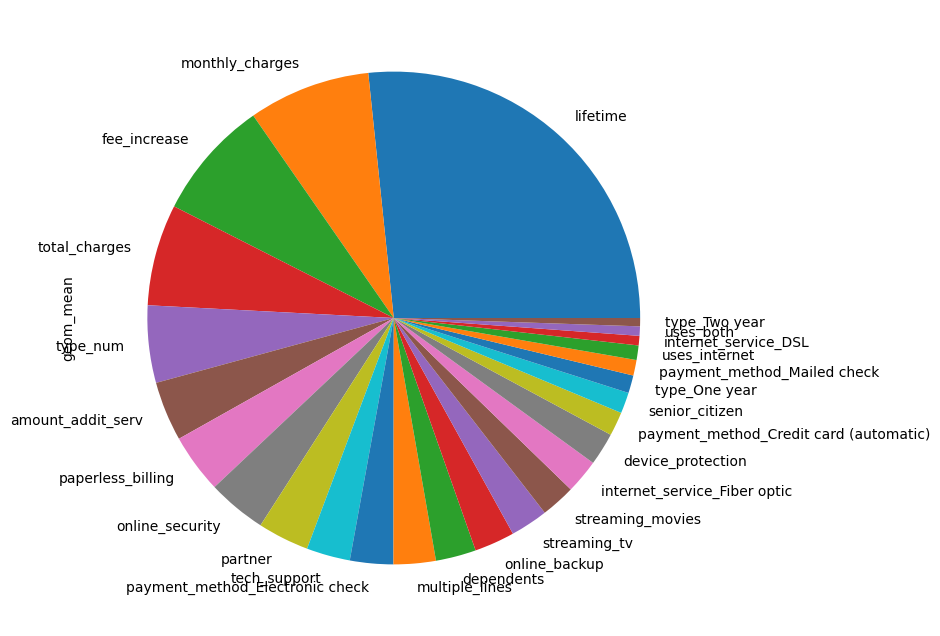

In [46]:
# Построение графиков
f_i[['feature_names','geom_mean']].set_index('feature_names').plot(kind='pie',subplots=True, figsize=(8,8),legend=False)

In [47]:
upsampling_features_importance={}
upsampling_features_importance['CBC'] = pd.DataFrame({'feature_names': features_train.columns,
              'CBC_feature_importance': model_imb['CBC']['classifier'].get_feature_importance()}
            ).sort_values(by=['CBC_feature_importance'], ascending=False).reset_index(drop=True)
drop_column = upsampling_features_importance['CBC']['feature_names'].values
upsampling_features_importance['CBC'].head(10)

feature_names  CBC_feature_importance
0           lifetime               30.811573
1            partner                6.058155
2  paperless_billing                5.417800
3    online_security                4.960089
4     multiple_lines                4.489794
5           type_num                4.183196
6         dependents                3.950256
7  device_protection                3.814225
8    monthly_charges                3.577615
9       tech_support                3.427410

In [48]:
NUMB_FEATURES = features_train.shape[1]

In [49]:
%%time
# Анализ изменения ROC-AUC при исключении признаков CBC
roc_auc_max = 0
roc_auc_max_ind = 0
for i in range(1,NUMB_FEATURES):
    scores = cross_validate(model_imb['CBC'], features_train.drop(drop_column[-i:],axis=1), target_train, scoring=('accuracy','roc_auc'), cv=5, n_jobs=-1)
    #print(f'Признаков {NUMB_FEATURES-i}, метрики: ACC - {scores["test_accuracy"].mean():.4f}, ROC-AUC - {scores["test_roc_auc"].mean():.4f}')
    if scores["test_roc_auc"].mean() > roc_auc_max:
        roc_auc_max = scores["test_roc_auc"].mean()
        roc_auc_max_ind = NUMB_FEATURES-i
print(f'Максимальный ROC-AUC {roc_auc_max:.4f}, количество признаков - {roc_auc_max_ind}' )

Максимальный ROC-AUC 0.9225, количество признаков - 6
CPU times: total: 375 ms
Wall time: 1min 58s


In [50]:
upsampling_features_importance['LGBMC'] = pd.DataFrame({'feature_names': features_train.columns,
              'LGBMC_feature_importance': model_imb['LGBMC']['classifier'].feature_importances_}
            ).sort_values(by=['LGBMC_feature_importance'], ascending=False).reset_index(drop=True)
drop_column = upsampling_features_importance['LGBMC']['feature_names'].values
upsampling_features_importance['LGBMC'].head(10)

feature_names  LGBMC_feature_importance
0           lifetime                       976
1       fee_increase                       351
2    monthly_charges                       326
3      total_charges                       231
4  amount_addit_serv                       122
5           type_num                        87
6  paperless_billing                        81
7    online_security                        78
8       tech_support                        72
9      online_backup                        70

In [51]:
%%time
# Анализ изменения ROC-AUC при исключении признаков LGBMC
roc_auc_max = 0
roc_auc_max_ind = 0
for i in range(1,NUMB_FEATURES):
    scores = cross_validate(model_imb['LGBMC'], features_train.drop(drop_column[-i:],axis=1), target_train, scoring=('accuracy','roc_auc'), cv=5, n_jobs=-1)
    #print(f'Признаков {NUMB_FEATURES-i}, метрики: ACC - {scores["test_accuracy"].mean():.4f}, ROC-AUC - {scores["test_roc_auc"].mean():.4f}')
    if scores["test_roc_auc"].mean() > roc_auc_max:
        roc_auc_max = scores["test_roc_auc"].mean()
        roc_auc_max_ind = NUMB_FEATURES-i
print(f'Максимальный ROC-AUC {roc_auc_max:.4f}, количество признаков - {roc_auc_max_ind}' )

Максимальный ROC-AUC 0.9176, количество признаков - 1
CPU times: total: 328 ms
Wall time: 5.94 s


In [52]:
upsampling_features_importance['RFC'] = pd.DataFrame({'feature_names': features_train.columns,
              'RFC_feature_importance': model_imb['RFC']['classifier'].feature_importances_}
            ).sort_values(by=['RFC_feature_importance'], ascending=False).reset_index(drop=True)
drop_column = upsampling_features_importance['RFC']['feature_names'].values
upsampling_features_importance['RFC'].head(10)

feature_names  RFC_feature_importance
0                         lifetime                0.141543
1                    total_charges                0.109075
2                  monthly_charges                0.098957
3                     fee_increase                0.090964
4                         type_num                0.080257
5                    type_Two year                0.054814
6     internet_service_Fiber optic                0.045147
7                amount_addit_serv                0.041588
8                  online_security                0.033734
9  payment_method_Electronic check                0.031442

In [53]:
%%time
# Анализ изменения ROC-AUC при исключении признаков RFC
roc_auc_max = 0
roc_auc_max_ind = 0
for i in range(1,NUMB_FEATURES):
    scores = cross_validate(model_imb['RFC'], features_train.drop(drop_column[-i:],axis=1), target_train, scoring=('accuracy','roc_auc'), cv=5, n_jobs=-1)
    #print(f'Признаков {NUMB_FEATURES-i}, метрики: ACC - {scores["test_accuracy"].mean():.4f}, ROC-AUC - {scores["test_roc_auc"].mean():.4f}')
    if scores["test_roc_auc"].mean() > roc_auc_max:
        roc_auc_max = scores["test_roc_auc"].mean()
        roc_auc_max_ind = NUMB_FEATURES-i
print(f'Максимальный ROC-AUC {roc_auc_max:.4f}, количество признаков - {roc_auc_max_ind}' )

Максимальный ROC-AUC 0.9272, количество признаков - 1
CPU times: total: 312 ms
Wall time: 20.7 s


###  Вывод 
CatBoostClassifier, LGBMClassifier и RandomForestClassifier с ненастроеными гиперпараметрами имеют максимум ROC-AUC при использовании 1-6 признаков.

## Графики roc-auc при сокращении числа признаков

features
rank                                        
1                                   lifetime
2                            monthly_charges
3                               fee_increase
4                              total_charges
5                                   type_num
6               internet_service_Fiber optic
7                          amount_addit_serv
8                payment_method_Mailed check
9                          paperless_billing
10                            multiple_lines
11                              streaming_tv
12                            senior_citizen
13                          streaming_movies
14           payment_method_Electronic check
15                           online_security
16                                dependents
17    payment_method_Credit card (automatic)
18                             uses_internet
19                              tech_support
20                                 uses_both
21                             online_backup
22                                   partner
23                      internet_service_DSL
24                             type_One year
25                         device_protection
26                             type_Two year

CPU times: total: 1h 4min 28s
Wall time: 8min 2s


array(['lifetime'], dtype=object)

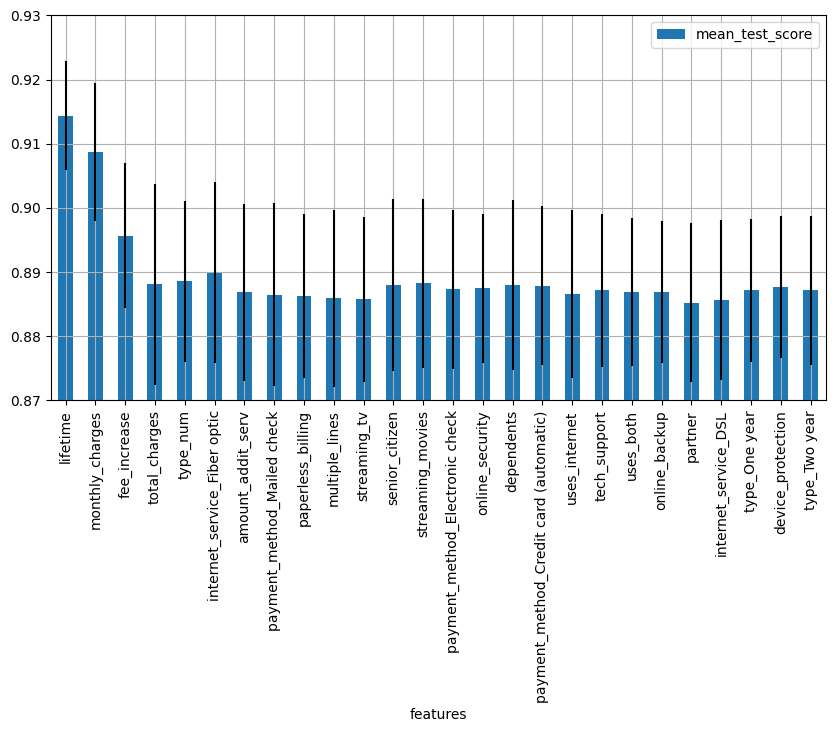

In [54]:
%%time
selectorr = RFECV(CatBoostClassifier (auto_class_weights='Balanced',random_state=RANDOM_STATE, silent=True),
                  step=1, cv=5, scoring='roc_auc',min_features_to_select=1)
selectorr = selectorr.fit(features_train, target_train)

feat=pd.DataFrame(data= {'features':features_train.columns.values, 'rank':selectorr.ranking_}).set_index('rank').sort_values(by='rank')
display(feat)
pd.DataFrame(data=selectorr.cv_results_,index=feat['features']).plot(y="mean_test_score", yerr="std_test_score", figsize=(10,5), grid=True, kind='bar', ylim=(0.87,0.93))
features_train.columns.values[selectorr.support_]

features
rank                                        
1                            monthly_charges
1                                   lifetime
2                               fee_increase
3                              total_charges
4                          amount_addit_serv
5                                   type_num
6                          paperless_billing
7                             multiple_lines
8                              online_backup
9                               tech_support
10                           online_security
11                                   partner
12                              streaming_tv
13                          streaming_movies
14           payment_method_Electronic check
15                                dependents
16              internet_service_Fiber optic
17               payment_method_Mailed check
18                         device_protection
19                            senior_citizen
20    payment_method_Credit card (automatic)
21                             uses_internet
22                             type_One year
23                                 uses_both
24                      internet_service_DSL
25                             type_Two year

CPU times: total: 4min 21s
Wall time: 18.3 s


array(['monthly_charges', 'lifetime'], dtype=object)

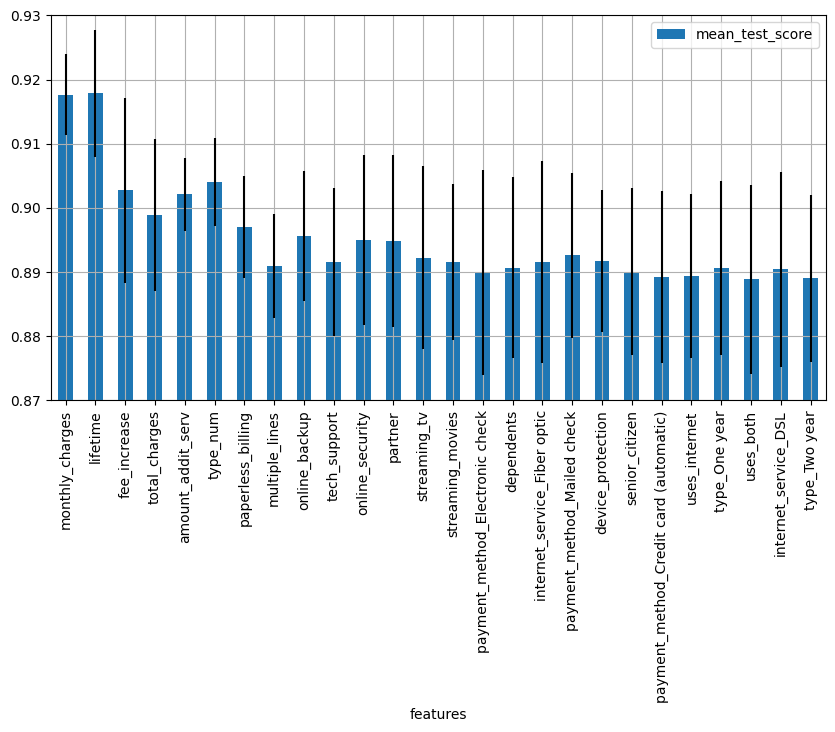

In [55]:
%%time
selectorr = RFECV(model_imb['LGBMC'],
                  step=1, cv=5, scoring='roc_auc', min_features_to_select=1, 
                  importance_getter="named_steps.classifier.feature_importances_")
selectorr = selectorr.fit(features_train, target_train)
feat=pd.DataFrame(data= {'features':features_train.columns.values, 'rank':selectorr.ranking_}).set_index('rank').sort_values(by='rank')
display(feat)
pd.DataFrame(data=selectorr.cv_results_,index=feat['features']).plot(y="mean_test_score", yerr="std_test_score", figsize=(10,5), grid=True, kind='bar', ylim=(0.87,0.93))
features_train.columns.values[selectorr.support_]

features
rank                                        
1                                   lifetime
2                            monthly_charges
3                              total_charges
4                                   type_num
5                               fee_increase
6               internet_service_Fiber optic
7                          amount_addit_serv
8                              type_Two year
9            payment_method_Electronic check
10                         paperless_billing
11                                   partner
12                           online_security
13                             uses_internet
14                                dependents
15                             online_backup
16                              tech_support
17                          streaming_movies
18                            multiple_lines
19                             type_One year
20                              streaming_tv
21                            senior_citizen
22                         device_protection
23                      internet_service_DSL
24    payment_method_Credit card (automatic)
25                                 uses_both
26               payment_method_Mailed check

CPU times: total: 1min 22s
Wall time: 1min 1s


array(['lifetime'], dtype=object)

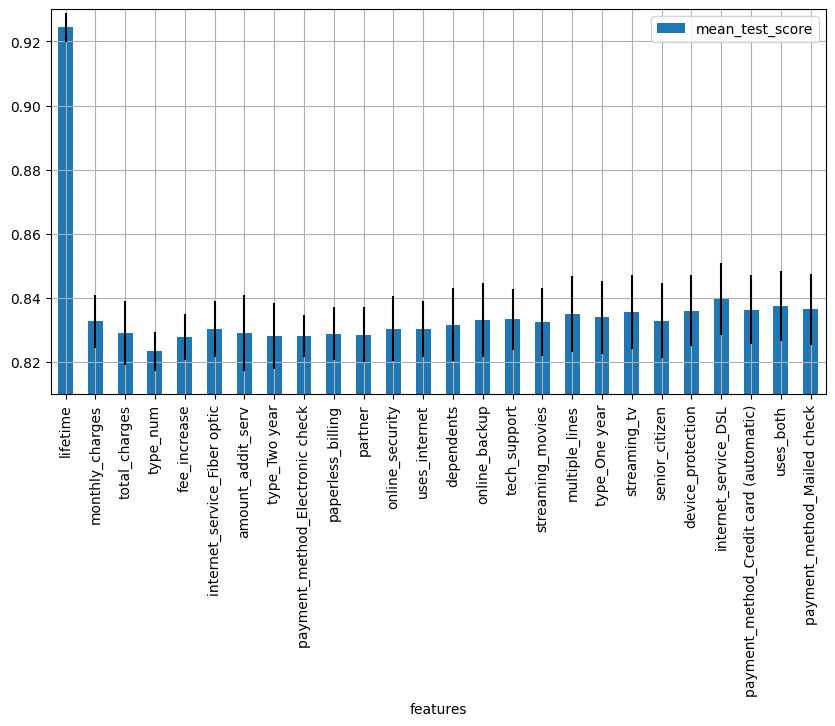

In [56]:
%%time

selectorr = RFECV(model_imb['RFC'], 
                  step=1, cv=3, scoring='roc_auc',min_features_to_select=1, 
                  importance_getter="named_steps.classifier.feature_importances_")
selectorr = selectorr.fit(features_train, target_train)
feat=pd.DataFrame(data= {'features':features_train.columns.values, 'rank':selectorr.ranking_}).set_index('rank').sort_values(by='rank')
display(feat)
pd.DataFrame(data=selectorr.cv_results_,index=feat['features']).plot(y="mean_test_score", yerr="std_test_score", figsize=(10,5), grid=True, kind='bar', ylim=(0.81,0.93))
features_train.columns.values[selectorr.support_]

##  Вывод 
- Без подбора гиперпараметров лучшие результаты кросс-валидации имеют модели CatBoostClassifier, LGBMClassifier и RandomForestClassifier. 
- Худшие результаты дает кросс-валидация при устранении дисбаланса классов методом downsampling. Поэтому при подборе гиперпараметров  рассматриваются модели с оверсемплингом методом SMOTE и RandomOverSampler.
- Исследование важности не позволяет достоверно выявить оптимальное количество и набор признаков, оптимизирующих метрики ROC- AUC для разных моделей. Модели имеют максимумы при использовании от 1 до 6 признаков.


# Подбор гиперпараметров

Создать пайплайны из скалера, селектора, сэмплера и классификаторов ()

In [57]:
grid_cv = {}
pipe = {}

In [58]:
# оценщик для селектора
def my_mutual_info_classif(X, y, discrete_features='auto', n_neighbors=10, copy=True, random_state=RANDOM_STATE):
    return mutual_info_classif(X, y, discrete_features=discrete_features, n_neighbors=n_neighbors, copy=copy, random_state=RANDOM_STATE)

## LGBMClassifier

### LGBMC RandomOverSampler

LGBMC_ROS модель с балансировкой RandomOverSampler
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyper parameter: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 2, 'classifier__n_estimators': 893, 'selector__param': 4}
Best hyper score: 0.9451
Значимые признаки: ['lifetime' 'type_num' 'type_Two year' 'internet_service_Fiber optic']
CPU times: total: 4.92 s
Wall time: 37.4 s


<AxesSubplot:title={'center':'Взаимная информация признаков'}>

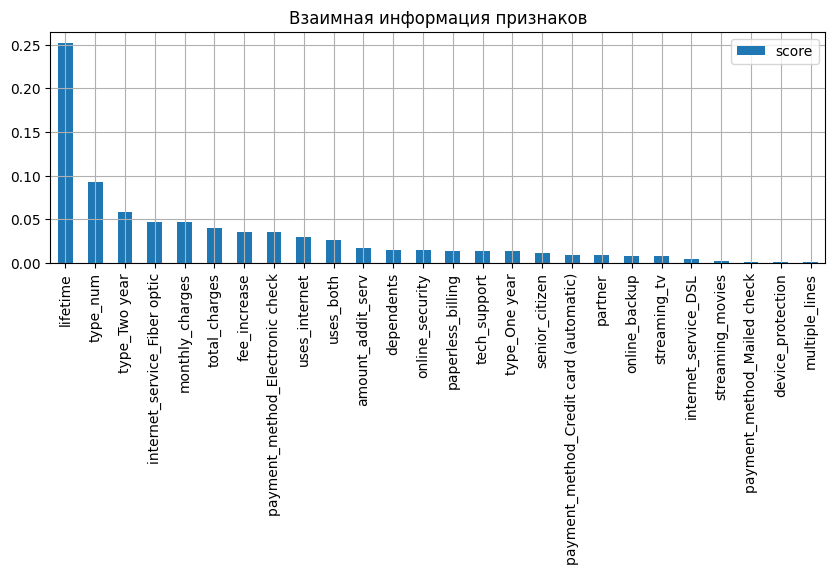

In [59]:
%%time
# LGBMC модель с балансировкой RandomOverSampler
model_type = "LGBMC_ROS"
print( model_type, 'модель с балансировкой RandomOverSampler')

params = {
 "selector__param": np.arange(3,7),#[3,4,5],#
 "classifier__n_estimators" : np.arange(892,895,1),
 "classifier__max_depth" : [2,3],
 "classifier__learning_rate" : [0.299,0.30,0.301]# np.arange(0.22,0.45,0.005)
 }

# Создание pipeline Создание селектора и добавление в пайплайн
pipe [model_type] = ImbPipeline([("scaler", StandardScaler()),
                                 ("selector", GenericUnivariateSelect(score_func=my_mutual_info_classif, mode='k_best')),
                                 ("sampler", RandomOverSampler(random_state=RANDOM_STATE)),
                                 ("classifier",LGBMClassifier(random_state=RANDOM_STATE))])

#importance_column
imp_col = features_train.columns
#imp_col = ['lifetime', 'type_num','internet_service_Fiber optic', 'monthly_charges', 'total_charges','payment_method_Electronic check']#, 'fee_increase', 'monthly_charges', 'total_charges', 'amount_addit_serv', 'payment_method']

grid_cv[model_type] = GridSearchCV(pipe[model_type], param_grid=params, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1, return_train_score=True);
grid_cv[model_type].fit(features_train[imp_col], target_train)

print("Best hyper parameter:", grid_cv[model_type].best_params_)
print(f'Best hyper score: {grid_cv[model_type].best_score_:.4f}')

imp_features = features_train[imp_col].columns.values[grid_cv[model_type].best_estimator_['selector'].get_support()]
print('Значимые признаки:', imp_features )
# (pd.DataFrame(data={'score': grid_cv[model_type].best_estimator_['classifier'].feature_importances_}, index=imp_features
#              ).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False));
(pd.DataFrame(data={'score':grid_cv[model_type].best_estimator_['selector'].scores_},
              index= features_train.columns)
 .sort_values(by='score',ascending=False)
 .plot(kind='bar',title ='Взаимная информация признаков',figsize=(10,3),grid=True)
);

LGBMC_ROS модель с балансировкой RandomOverSampler
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyper parameter: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 2, 'classifier__n_estimators': 893, 'selector__param': 4}
Best hyper score: 0.9451
Значимые признаки: ['lifetime' 'type_num' 'type_Two year' 'internet_service_Fiber optic']
CPU times: total: 4.89 s
Wall time: 33.4 s

### LGBMC SMOTE

In [60]:
%%time
# LGBMC модель с балансировкой SMOTE
model_type = "LGBMC_SMOTE"
print( model_type, 'модель с балансировкой SMOTE')

params = {
 "selector__param": np.arange(3,7),#[3,4,5],#
 "classifier__n_estimators" : np.arange(892,895,1),
 "classifier__max_depth" : [2],
 "classifier__learning_rate" : [0.298,0.299,0.3]# np.arange(0.22,0.45,0.005)
 }

# Создание pipeline Создание селектора и добавление в пайплайн
pipe [model_type] = ImbPipeline([("scaler", StandardScaler()),
                                 ("selector", GenericUnivariateSelect(score_func=my_mutual_info_classif, mode='k_best')),
                                 ("sampler", SMOTE(random_state=RANDOM_STATE)),
                                 ("classifier",LGBMClassifier(random_state=RANDOM_STATE))])

#importance_column
imp_col = features_train.columns
#imp_col = ['lifetime', 'type_num','internet_service_Fiber optic', 'monthly_charges', 'total_charges','payment_method_Electronic check']#, 'fee_increase', 'monthly_charges', 'total_charges', 'amount_addit_serv', 'payment_method']

grid_cv[model_type] = GridSearchCV(pipe[model_type], param_grid=params, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1, return_train_score=True);
grid_cv[model_type].fit(features_train[imp_col], target_train)

print("Best hyper parameter:", grid_cv[model_type].best_params_)
print(f'Best hyper score: {grid_cv[model_type].best_score_:.4f}')

imp_features = features_train[imp_col].columns.values[grid_cv[model_type].best_estimator_['selector'].get_support()]
print('Значимые признаки:', imp_features )
# (pd.DataFrame(data={'score': grid_cv[model_type].best_estimator_['classifier'].feature_importances_}, index=imp_features
#              ).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False));

LGBMC_SMOTE модель с балансировкой SMOTE
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyper parameter: {'classifier__learning_rate': 0.299, 'classifier__max_depth': 2, 'classifier__n_estimators': 893, 'selector__param': 4}
Best hyper score: 0.9478
Значимые признаки: ['lifetime' 'type_num' 'type_Two year' 'internet_service_Fiber optic']
CPU times: total: 3.14 s
Wall time: 16.9 s


In [61]:
print(f'Train Accuracy: {accuracy_score(target_train, grid_cv[model_type].best_estimator_.predict(features_train[imp_col])):.4f}')
print(f'Test Accuracy: {accuracy_score(target_test, grid_cv[model_type].best_estimator_.predict(features_test[imp_col])):.4f}')
print(f'Test AUC_ROC: {roc_auc_score(target_test, grid_cv[model_type].best_estimator_.predict(features_test[imp_col])):.4f}')
for i in confusion_matrix, recall_score, precision_score, f1_score:
    print(i,'\n',i(target_test, grid_cv[model_type].best_estimator_.predict(features_test[imp_col])))    

Train Accuracy: 0.8834
Test Accuracy: 0.8815
Test AUC_ROC: 0.8635
<function confusion_matrix at 0x000002E40F52A5F0> 
 [[921  98]
 [ 69 321]]
<function recall_score at 0x000002E40F52AD40> 
 0.823076923076923
<function precision_score at 0x000002E40F52ACB0> 
 0.766109785202864
<function f1_score at 0x000002E40F52A950> 
 0.7935723114956736


### LGBMC with SMOTE, OPTUNA

In [62]:
imp_col = features_train.columns
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',1100,1500,step=10)
    max_depth = trial.suggest_int('max_depth',2,3,step=1)
    num_leaves  = trial.suggest_int('num_leaves ',20,35,step=1)
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt"])#, "dart", "goss"
    learning_rate = trial.suggest_float("learning_rate", 0.3, 0.5, step=0.005)
    param = trial.suggest_int('param',1,6,step=1)
    ## Create Model
    pipe ['LGBMC'] = ImbPipeline([("scaler", StandardScaler()),
                                     ("selector", GenericUnivariateSelect(my_mutual_info_classif,mode='k_best', param=param)),
                                     ("sampler", SMOTE(random_state=RANDOM_STATE)),
                                     ("classifier",LGBMClassifier (n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                                         num_leaves=num_leaves, boosting_type=boosting_type, random_state=RANDOM_STATE,class_weight='balanced'))])
    scores = cross_validate(pipe['LGBMC'], features_train[imp_col], target_train, scoring='roc_auc', cv=5, n_jobs=-1)
   

    return scores["test_score"].mean()

In [63]:
%%time
study = optuna.create_study(study_name="ImbPipeline", direction="maximize")
study.optimize(objective, n_trials=200,show_progress_bar=True)

[I 2022-09-03 16:42:13,784] A new study created in memory with name: ImbPipeline
C:\Users\Vasekk\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2022-09-03 16:42:15,090] Trial 0 finished with value: 0.9447939953353586 and parameters: {'n_estimators': 1280, 'max_depth': 3, 'num_leaves ': 29, 'boosting_type': 'gbdt', 'learning_rate': 0.33999999999999997, 'param': 4}. Best is trial 0 with value: 0.9447939953353586.
[I 2022-09-03 16:42:16,332] Trial 1 finished with value: 0.9450704119955482 and parameters: {'n_estimators': 1250, 'max_depth': 3, 'num_leaves ': 29, 'boosting_type': 'gbdt', 'learning_rate': 0.33499999999999996, 'param': 4}. Best is trial 1 with value: 0.9450704119955482.
[I 2022-09-03 16:42:17,452] Trial 2 finished with value: 0.9476740668650049 and parameters: {'n_estimators': 1470, 'max_depth': 2, 'num_leaves ': 35, 'boosting_type': 'gbdt', 'learning_rate': 0.305, 'param': 4}. Best is trial 2 with value: 0.9476740668650049.
[I 2022-09-03 16:42:18,622] Trial 3 finished with value: 0.920536694223441 and parameters: {'n_estimators': 1130, 'max_depth': 3, 'num_leaves ': 23, 'boosting_type': 'gbdt', 'learning_rate': 0

Best LGBMC Params : {'n_estimators': 1463, 'max_depth': 2, 'num_leaves ': 26, 'boosting_type': 'gbdt', 'learning_rate': 0.33499999999999996, 'param': 4}

Best LGBMC cross_val ROC_AUC : 0.948116841218628

Best LGBMC Params : {'n_estimators': 1250, 'max_depth': 2, 'num_leaves ': 27, 'boosting_type': 'gbdt', 'learning_rate': 0.355, 'param': 4}

Best LGBMC cross_val ROC_AUC : 0.9480034472151893


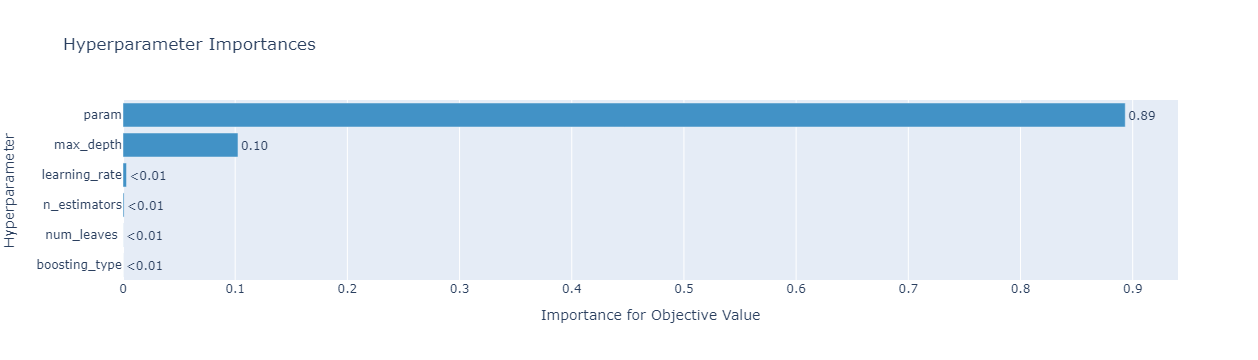

In [64]:
print("Best LGBMC Params : {}".format(study.best_params))

print("\nBest LGBMC cross_val ROC_AUC : {}".format(study.best_value))

fig = optuna.visualization.plot_param_importances(study)
fig.show()

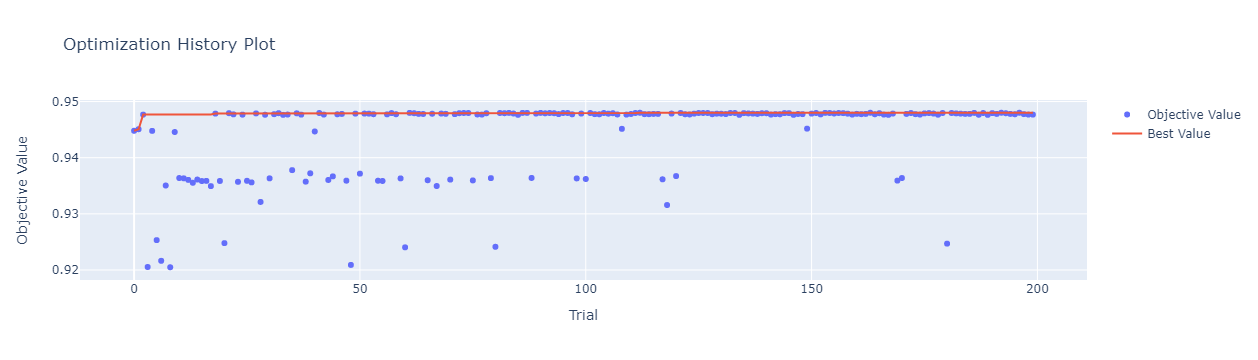

In [65]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [66]:
pipe ['LGBMC'] = ImbPipeline([("scaler", StandardScaler()),
                                 ("selector", GenericUnivariateSelect(my_mutual_info_classif,mode='k_best', param=4)),
                                 ("sampler", SMOTE(random_state=RANDOM_STATE)),
                                 ("classifier",CatBoostClassifier (n_estimators=1020, max_depth=2, learning_rate=0.28,
                                     random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced'))])
pipe ['LGBMC'].fit(features_train[imp_col], target_train)
print(f"Train AUC_ROC: {roc_auc_score(target_train, pipe['LGBMC'].predict(features_train[imp_col])):.4f}")
print(f"Train Accuracy: {accuracy_score(target_train, pipe['LGBMC'].predict(features_train[imp_col])):.4f}")
print(f"Test Accuracy: {accuracy_score(target_test, pipe ['LGBMC'].predict(features_test[imp_col])):.4f}")
print(f"Test AUC_ROC: {roc_auc_score(target_test, pipe ['LGBMC'].predict(features_test[imp_col])):.4f}")
for i in confusion_matrix, recall_score, precision_score, f1_score:
    print(i,'\n',i(target_test, pipe ['LGBMC'].predict(features_test[imp_col]))) 

Train AUC_ROC: 0.8798
Train Accuracy: 0.8834
Test Accuracy: 0.8829
Test AUC_ROC: 0.8652
<function confusion_matrix at 0x000002E40F52A5F0> 
 [[922  97]
 [ 68 322]]
<function recall_score at 0x000002E40F52AD40> 
 0.8256410256410256
<function precision_score at 0x000002E40F52ACB0> 
 0.7684964200477327
<function f1_score at 0x000002E40F52A950> 
 0.796044499381953


## RandomForestClassifier

### RFC SMOTE

In [67]:
%%time
# RFC модель со встроенной балансировкой
model_type = "RFC_SMOTE"
print( model_type, 'модель с балансировкой SMOTE')

params = {
 "selector__param": np.arange(1,4),
 "classifier__n_estimators" : np.arange(501,504,1),#[ 1000,1050, 1100],
 "classifier__max_depth" : np.arange(39,42,1),#[40, 45, 50, 75, 100],
 "classifier__criterion" : ['gini']
 }

# Создание pipeline Создание селектора и добавление в пайплайн
pipe [model_type] = ImbPipeline([("scaler", StandardScaler()),
                                 ("selector", GenericUnivariateSelect(score_func=my_mutual_info_classif, mode='k_best')),
                                 ("sampler", SMOTE(random_state=RANDOM_STATE)),
                              ("classifier",RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])

#importance_column
imp_col = features_train.columns

grid_cv[model_type] = GridSearchCV(pipe[model_type], param_grid=params, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1, return_train_score=True);
grid_cv[model_type].fit(features_train[imp_col], target_train)

print("Best hyper parameter:", grid_cv[model_type].best_params_)
print(f'Best hyper score: {grid_cv[model_type].best_score_:.4f}')

imp_features = features_train[imp_col].columns.values[grid_cv[model_type].best_estimator_['selector'].get_support()]
print('Значимые признаки:', imp_features )
# (pd.DataFrame(data={'score': grid_cv[model_type].best_estimator_['classifier'].get_feature_importance()}, index=imp_features
#              ).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False));

RFC_SMOTE модель с балансировкой SMOTE
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyper parameter: {'classifier__criterion': 'gini', 'classifier__max_depth': 40, 'classifier__n_estimators': 502, 'selector__param': 1}
Best hyper score: 0.9274
Значимые признаки: ['lifetime']
CPU times: total: 2.41 s
Wall time: 35.2 s


### RFC RandomOverSampler

In [68]:
%%time
# RFC модель со встроенной балансировкой
model_type = "RFC_ROS"
print( model_type, 'модель с балансировкой RandomOverSampler')

params = {
 "selector__param": np.arange(1,4),
 "classifier__n_estimators" : np.arange(272,275,1),#[ 1000,1050, 1100],
 "classifier__max_depth" : np.arange(34,37,1),#[40, 45, 50, 75, 100],
 "classifier__criterion" : ['gini']
 }

# Создание pipeline Создание селектора и добавление в пайплайн
pipe [model_type] = ImbPipeline([("scaler", StandardScaler()),
                                 ("selector", GenericUnivariateSelect(score_func=my_mutual_info_classif, mode='k_best')),
                                 ("sampler", RandomOverSampler(random_state=RANDOM_STATE)),
                              ("classifier",RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])

#importance_column
imp_col = features_train.columns

grid_cv[model_type] = GridSearchCV(pipe[model_type], param_grid=params, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1, return_train_score=True);
grid_cv[model_type].fit(features_train[imp_col], target_train)

print("Best hyper parameter:", grid_cv[model_type].best_params_)
print(f'Best hyper score: {grid_cv[model_type].best_score_:.4f}')

imp_features = features_train[imp_col].columns.values[grid_cv[model_type].best_estimator_['selector'].get_support()]
print('Значимые признаки:', imp_features )
# (pd.DataFrame(data={'score': grid_cv[model_type].best_estimator_['classifier'].get_feature_importance()}, index=imp_features
#              ).sort_values(by='score').plot(kind='barh', grid=True, figsize=(6,6), legend=False));

RFC_ROS модель с балансировкой RandomOverSampler
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyper parameter: {'classifier__criterion': 'gini', 'classifier__max_depth': 35, 'classifier__n_estimators': 273, 'selector__param': 1}
Best hyper score: 0.9287
Значимые признаки: ['lifetime']
CPU times: total: 1.81 s
Wall time: 21.7 s


In [69]:
print(f'Train Accuracy: {accuracy_score(target_train, grid_cv[model_type].best_estimator_.predict(features_train[imp_col])):.4f}')
print(f'Test Accuracy: {accuracy_score(target_test, grid_cv[model_type].best_estimator_.predict(features_test[imp_col])):.4f}')
print(f'Test AUC_ROC: {roc_auc_score(target_test, grid_cv[model_type].best_estimator_.predict(features_test[imp_col])):.4f}')
for i in confusion_matrix, recall_score, precision_score, f1_score:
    print(i,'\n',i(target_test, grid_cv[model_type].best_estimator_.predict(features_test[imp_col])))    

Train Accuracy: 0.8612
Test Accuracy: 0.8666
Test AUC_ROC: 0.8492
<function confusion_matrix at 0x000002E40F52A5F0> 
 [[905 114]
 [ 74 316]]
<function recall_score at 0x000002E40F52AD40> 
 0.8102564102564103
<function precision_score at 0x000002E40F52ACB0> 
 0.7348837209302326
<function f1_score at 0x000002E40F52A950> 
 0.7707317073170732


## CatBoostClassifier with OPTUNA

### CBC SMOTE

In [70]:
imp_col = features_train.columns
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',500,1500,step=5)
    max_depth = trial.suggest_int('max_depth',2,4,step=1)
    learning_rate = trial.suggest_float("learning_rate", 0.1, 0.7, step=0.01)
    param = trial.suggest_int('param',1,10,step=1)
    ## Create Model
    pipe ['CBC_SMOTE'] = ImbPipeline([("scaler", StandardScaler()),
                                     ("selector", GenericUnivariateSelect(my_mutual_info_classif,mode='k_best', param=param)),
                                     ("sampler", SMOTE(random_state=RANDOM_STATE)),
                                     ("classifier",CatBoostClassifier (n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                                         random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced'))])
    scores = cross_validate(pipe['CBC_SMOTE'], features_train[imp_col], target_train, scoring='roc_auc', cv=5, n_jobs=-1)
   

    return scores["test_score"].mean()

In [71]:
%%time
study = optuna.create_study(study_name="ImbPipeline", direction="maximize")
study.optimize(objective, n_trials=200,show_progress_bar=True)

[I 2022-09-03 16:46:52,022] A new study created in memory with name: ImbPipeline
C:\Users\Vasekk\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/200 [00:00<?, ?it/s]

[I 2022-09-03 16:46:55,747] Trial 0 finished with value: 0.9332719038869991 and parameters: {'n_estimators': 980, 'max_depth': 3, 'learning_rate': 0.31, 'param': 7}. Best is trial 0 with value: 0.9332719038869991.
[I 2022-09-03 16:46:59,267] Trial 1 finished with value: 0.9354748237805204 and parameters: {'n_estimators': 1100, 'max_depth': 2, 'learning_rate': 0.65, 'param': 6}. Best is trial 1 with value: 0.9354748237805204.
[I 2022-09-03 16:47:02,785] Trial 2 finished with value: 0.9384779747011283 and parameters: {'n_estimators': 1065, 'max_depth': 3, 'learning_rate': 0.39, 'param': 2}. Best is trial 2 with value: 0.9384779747011283.
[I 2022-09-03 16:47:05,905] Trial 3 finished with value: 0.9457412670272916 and parameters: {'n_estimators': 950, 'max_depth': 3, 'learning_rate': 0.7, 'param': 4}. Best is trial 3 with value: 0.9457412670272916.
[I 2022-09-03 16:47:08,466] Trial 4 finished with value: 0.9311235380274112 and parameters: {'n_estimators': 775, 'max_depth': 3, 'learning_rat

Best Params : {'n_estimators': 1440, 'max_depth': 2, 'learning_rate': 0.48, 'param': 4}

Best cross_val ROC_AUC : 0.9495026095972984


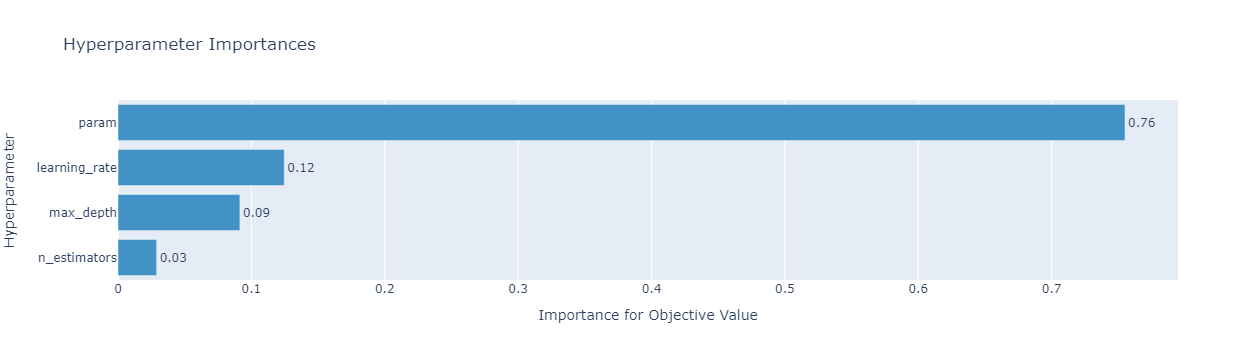

In [72]:
print("Best Params : {}".format(study.best_params))

print("\nBest cross_val ROC_AUC : {}".format(study.best_value))

fig = optuna.visualization.plot_param_importances(study)
fig.show()

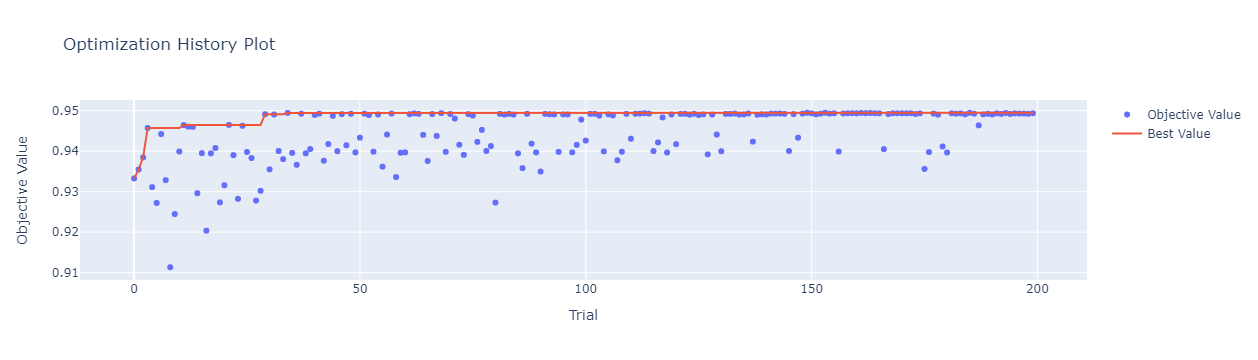

In [73]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

### CBC RandomOverSampler

In [74]:
imp_col = features_train.columns
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',500,1500,step=5)
    max_depth = trial.suggest_int('max_depth',2,4,step=1)
    learning_rate = trial.suggest_float("learning_rate", 0.1, 0.7, step=0.01)
    param = trial.suggest_int('param',1,10,step=1)
    ## Create Model
    pipe ['CBC_ROS'] = ImbPipeline([("scaler", StandardScaler()),
                                     ("selector", GenericUnivariateSelect(my_mutual_info_classif,mode='k_best', param=param)),
                                     ("sampler", RandomOverSampler(random_state=RANDOM_STATE)),
                                     ("classifier",CatBoostClassifier (n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                                         random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced'))])
    scores = cross_validate(pipe['CBC_ROS'], features_train[imp_col], target_train, scoring='roc_auc', cv=5, n_jobs=-1)
   

    return scores["test_score"].mean()

In [75]:
%%time
study = optuna.create_study(study_name="ImbPipeline", direction="maximize")
study.optimize(objective, n_trials=200,show_progress_bar=True)

[I 2022-09-03 16:57:33,489] A new study created in memory with name: ImbPipeline
C:\Users\Vasekk\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/200 [00:00<?, ?it/s]

[I 2022-09-03 16:57:36,049] Trial 0 finished with value: 0.9445956709018877 and parameters: {'n_estimators': 940, 'max_depth': 3, 'learning_rate': 0.66, 'param': 4}. Best is trial 0 with value: 0.9445956709018877.
[I 2022-09-03 16:57:39,135] Trial 1 finished with value: 0.921447298427351 and parameters: {'n_estimators': 1235, 'max_depth': 2, 'learning_rate': 0.19, 'param': 8}. Best is trial 0 with value: 0.9445956709018877.
[I 2022-09-03 16:57:41,425] Trial 2 finished with value: 0.9398579977211501 and parameters: {'n_estimators': 920, 'max_depth': 2, 'learning_rate': 0.41000000000000003, 'param': 2}. Best is trial 0 with value: 0.9445956709018877.
[I 2022-09-03 16:57:43,488] Trial 3 finished with value: 0.9285950620509759 and parameters: {'n_estimators': 725, 'max_depth': 3, 'learning_rate': 0.56, 'param': 1}. Best is trial 0 with value: 0.9445956709018877.
[I 2022-09-03 16:57:46,237] Trial 4 finished with value: 0.9214023925718535 and parameters: {'n_estimators': 1020, 'max_depth': 2

Best Params : {'n_estimators': 820, 'max_depth': 2, 'learning_rate': 0.37, 'param': 4}

Best cross_val ROC_AUC : 0.951459256325407


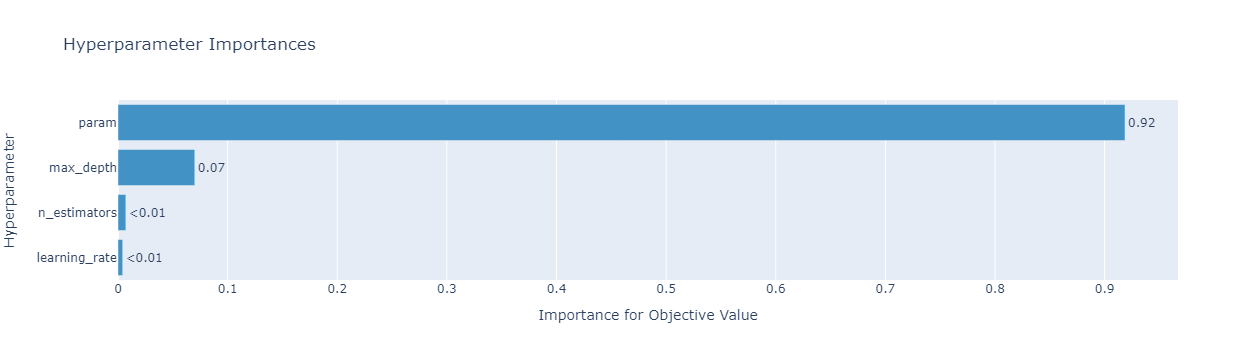

In [76]:
print("Best Params : {}".format(study.best_params))

print("\nBest cross_val ROC_AUC : {}".format(study.best_value))

fig = optuna.visualization.plot_param_importances(study)
fig.show()

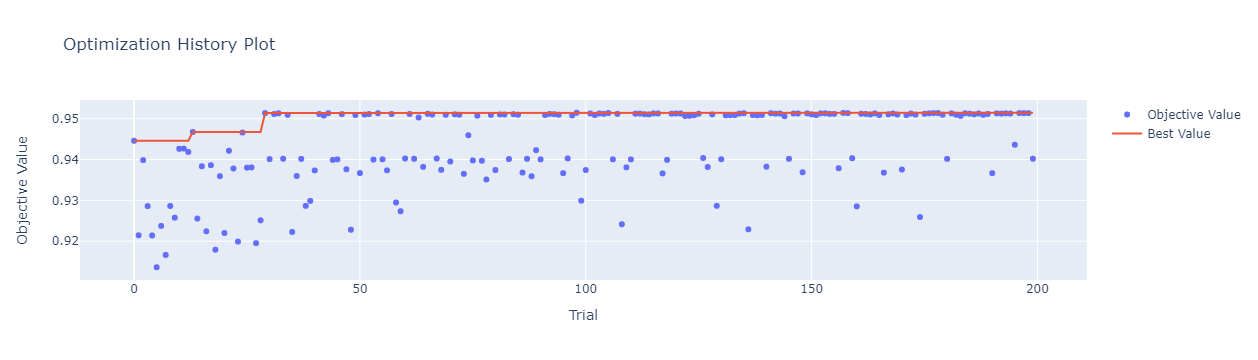

In [77]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [78]:
pipe ['CBC_ROS'] = ImbPipeline([("scaler", StandardScaler()),
                                 ("selector", GenericUnivariateSelect(my_mutual_info_classif,mode='k_best', param=4)),
                                 ("sampler", SMOTE(random_state=RANDOM_STATE)),
                                 ("classifier",CatBoostClassifier (n_estimators=1020, max_depth=2, learning_rate=0.28,
                                     random_state=RANDOM_STATE, silent=True, auto_class_weights='Balanced'))])
pipe ['CBC_ROS'].fit(features_train[imp_col], target_train)
print(f"Train AUC_ROC: {roc_auc_score(target_train, pipe['CBC_ROS'].predict(features_train[imp_col])):.4f}")
print(f"Train Accuracy: {accuracy_score(target_train, pipe['CBC_ROS'].predict(features_train[imp_col])):.4f}")
print(f"Test Accuracy: {accuracy_score(target_test, pipe ['CBC_ROS'].predict(features_test[imp_col])):.4f}")
print(f"Test AUC_ROC: {roc_auc_score(target_test, pipe ['CBC_ROS'].predict(features_test[imp_col])):.4f}")
for i in confusion_matrix, recall_score, precision_score, f1_score:
    print(i,'\n',i(target_test, pipe ['CBC_ROS'].predict(features_test[imp_col]))) 

Train AUC_ROC: 0.8798
Train Accuracy: 0.8834
Test Accuracy: 0.8829
Test AUC_ROC: 0.8652
<function confusion_matrix at 0x000002E40F52A5F0> 
 [[922  97]
 [ 68 322]]
<function recall_score at 0x000002E40F52AD40> 
 0.8256410256410256
<function precision_score at 0x000002E40F52ACB0> 
 0.7684964200477327
<function f1_score at 0x000002E40F52A950> 
 0.796044499381953


## Выводы по подбору гиперпараметров моделей
Подобраны гиперпараметры для моделей CatBoostClassifier, LGBMClassifier, LGBMClassifier.

Для подбора использованы GridSearchCV и Optuna. При использовании Optuna оптимизируемая метрика ROC-AUC была получена с использованием cross_validate.

При подборе гиперпараметров использовался пайплайн (imblearn) содержащий:
- скалер (стандартный скалер из sklearn)
- селектор ( GenericUnivariateSelect из sklearn) для подбора оптимального числа параметров.
- оверсемплер (RandomOverSampler или SMOTE из imblearn) для устранения дисбаланса классов
- классификатор ( CatBoostClassifier, LGBMClassifier, LGBMClassifier)

**Результаты расчета ROC-AUC**

|№ |Классификатор| Grid|Optuna|Rand_sampler|SMOTE| ROC-AUC_train |
|:-|:-----| :-: | :--: | :--------: |:---:| :-----------: |
| 1|LGBM  | +   |      |+           |     |0.9451         |
| 2|LGBM  | +   |      |            | +   |0.9478         |
| 3|LGBM  |     |  +   |     +      |     |~0.946         |
| 4|LGBM  |     |  +   |            | +   |0.9481         |
| 5|RFC   | +   |      |            | +   |0.9274         |
| 6|RFC   | +   |      |    +       |     |0.9287         |
| 7|CBC   |     |  +   |            | +   |0.9498         |
| 8|**CBC**   |     |  **+**   |**+**  |     |**0.9514**     |

**Наблюдения**

- Оверсемплинг SMOTE для LGBM повышает метрику по сравнению с Rand_sampler, а для двух других наоборот с Rand_sampler метрики выше. 

- Результаты Otpuna  для модели СВС и LGBM немного больше (на десятые доли процента) результатов, получаемых GridSearchCV

- Былы подобраны оптимальные признаки и их количество: для модели RFC - 1 параметр -'lifetime', а для бустинговых моделей - 4 параметра ( 'lifetime' 'type_num' 'type_Two year' 'internet_service_Fiber optic'). При этом два из параметров сильно связаны: 'type_num' - тип оплаты в месяцах: ежемесячный(1), годовой(12) и двухгодовой(24), а 'type_Two year' - логический признак является ли тип оплаты двухгодовым, однако исключение одного из признаков сокращает train_ROC_AUC.

**Наибольшая метрика ROC-AUC = 0.9514 (accuracy = 0.8834) наблюдается для модели CatBoostClassifier с балансировкой RandomOverSampler, параметры модели: 1 вариант 'n_estimators': 1020, 'max_depth': 2, 'learning_rate': 0.28. 2 вариант{'n_estimators': 820, 'max_depth': 2, 'learning_rate': 0.37}**

**Метрики на тестовой выборке:**
1. ROC-AUC = 0.8652, 
2. accuracy = 0.8829.

3. Матрица ошибок
|922|97|
|:-|:-----|
|**68**|**322**|

 т.е. верно предсказано, что: ушло 322 чел, 922 чел. остались; ошибочно предсказано, что 97 ушли и 68 остались.
 
4. Полнота 0.8256, т.е. модель предсказала 82,56 % клиентов, которые ушли, из всех ушедших. 
5. Точность 0.7685, т.е. модель 76,85 % из предсказанных клиентов действительно ушли, но 23,15% остались.
6. Мера F1 0.7960

# Общий вывод

В ходе работы было выполнено:

1. загружены и проанализированы исходные данные. Данные содержат информацию 
- о контрактах: BeginDate – дата начала пользования услугами, EndDate – дата окончания пользования услугами, Type – тип оплаты: ежемесячный, годовой и тд, PaperlessBilling – электронный документ об оплате, PaymentMethod – способ оплаты, MonthlyCharges – ежемесячные траты на услуги, TotalCharges – всего потрачено денег на услуги
о клиентах: gender - пол Senior Citizen – наличие пенсионного статуса по возрасту Partner – наличие супруга(и) Dependents – наличие иждивенцев

- об услугах интернета InternetService - тип подключения OnlineSecurity - блокировка небезопасных сайтов OnlineBackup - облачное хранилище файлов для резервного копирования данных DeviceProtection - антивирус TechSupport - выделенная линия технической поддержки StreamingTV - стриминговое телевидение StreamingMovies - каталог фильмов

- об услугах телефонии: MultipleLines – наличие возможности ведения параллельных линий во время звонка

- Количество записей о контрактах и клиентах совпадает(7043), записей об услугах интернета и телефонии меньше, что обусловлено, тем что часть клиентов пользуется только одной услугой. Проверено, что нет записей о клиентах, которые не пользуются ни одной услугой. В данных отсутствуют явные пропуски и явные дубликаты. У клиентов зарегистрировавщихся в день выгрузки базы отсутствовала запись о суммарных тратах, заполнена нулями. Названия столбцов приведены к змеиному регистру.

Выделены признак "Время жизни клиента" и целевой признак "Клиент ушел".

2. Подготовлены признаки для обучения моделей:
данные объеденены в один датафрейм,
заполнены появившиеся у клиентов с одной услугой пропуски во второй услуге,
сгенерированы новые признаки: периодирчость оплаты в месяцах, используется ли услуга интернета, обе услуги, количество используемых клиентом услуг.
закодированы категориальные признаки прямым кодированием;
подготовлены обучающая и тестовая выборки.

3. С учетом дисбаланса классов обучены модели CatBoostClassifier, LGBMClassifier, DecisionTreeClassifier, RandomForestClassifier, LogisticRegression.
Рассмотрены 4 метода устранения дисбаланса классов: 1) встроенная в модели балансировка, 2) dowsampling, 3) upsampling SMOTE и 4) RandomOverSampler. 
Наибольшие метрики получаются при использовании RandomOverSampler для моделей LGBMC (0.8917 и 8906) и CBC (0.8878 и 8872). Но наибольшее Accuracy для SMOTE, примерно на 2% больше чем для RandomOverSampler, а Roc-auc меньше на 0.2 %. Также отмечено, что при использовании скалера перед SMOTE метрики деревянных моделей увеличиваются. 

Рассмотрена значимость признаков для 3 лучших моделей и для двух методов балансировки. Значимость признаков варьируется от параметров, поэтому сложно выделить топ5 (или 10) наиболее значимых признаков. Самый значимый признак - время жизни клиентов. Максимальные метрики ROC-AUC наблюдаются при обучении на 1-6 признаках.

5. Выполнен подбор гиперпараметров для трех лучших моделей.
При подборе гипермараметров для определения наиболее значимых признаков и их количества с учетом их взаимной информации использован GenericUnivariateSelect с параметрами score_func=mutual_info_classif, mode='k_best'.
Для подбора гиперпараметров использовались методы GridSearchCV и Optuna.

**Наибольшая метрика ROC-AUC__cv = 0.9514 (accuracy_cv = 0.8834) получена для модели CatBoostClassifier с балансировкой RandomOverSampler, параметры модели: 'n_estimators': 1020, 'max_depth': 2, 'learning_rate': 0.28; для модели определено оптимальное количество признаков -4. Разработанная модель позволит прогнозировать отток клиентов оператора связи «Ниединогоразрыва.ком». Для прогнозирования необходимы признаки: 1) Время жизни клиента, 2) способ оплаты, 3) тип интернет подключения.** 

**Метрики на тестовой выборке:**
1. ROC-AUC = 0.8652, 
2. accuracy = 0.8829.

3. Матрица ошибок
922|97
:-|:-----
**68**|**322**

 т.е. верно предсказано, что: ушло 322 чел, 922 чел. остались; ошибочно предсказано, что 97 ушли и 68 остались.
 
4. Полнота 0.8256, т.е. модель предсказала 82,56 % клиентов, которые ушли, из всех ушедших. 
5. Точность 0.7685, т.е. модель 76,85 % из предсказанных клиентов действительно ушли, но 23,15% остались.
6. Мера F1 0.7960м


